<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# Creating DTC-Glaciers EO-Native data cubes (L1)

If required, install the DTCG API using the following command:

```
!pip install 'dtcg[jupyter] @ git+https://github.com/DTC-Glaciers/dtcg'
```

Run this command in a notebook cell.

In [1]:
# Imports
import dtcg.integration.oggm_bindings as oggm_bindings
import matplotlib.pyplot as plt

In this notebook we focuse on the creation of EO-Native Data cubes, in the following called **L1** data cubes. Those **L1** data cubes consist only of Earth Observation (EO) data and in-situ data. They are created for each glacier individually. All data within the data cube is projected on the same grid and prepared to be used within other parts of DTC-Glaciers later in the workflow.

To showcase the usage of different EO data sets we focuse in this notebook on the glaciers **Brúarjökull outlet glacier** in Vatnajökull Iceland and **Vernagtferner** in Ötztal Austria.

In [2]:
rgi_id_ice = "RGI60-06.00377"  # Brúarjökull
rgi_id_aut = "RGI60-11.00719"  # Vernagtferner

## Extract L1 data cubes from OGGM

DTC-Glaciers starts with glacier-domain data from the **[OGGM shop](https://docs.oggm.org/en/stable/shop.html)** (sourced from multiple providers) and packages it into a data cube. In the background this will download preprocessed **L1** data cubes from OGGM and prepares everything to run the model. Theirfore this can take some time.

In [3]:
dtcg_oggm_ice = oggm_bindings.BindingsOggmModel(rgi_id=rgi_id_ice)
dtcg_oggm_aut = oggm_bindings.BindingsOggmModel(rgi_id=rgi_id_aut)

Let's have a look what **OGGM** supports out of the box:

In [4]:
dtcg_oggm_aut.l1_datacube

<xarray.Dataset> Size: 3MB
Dimensions:                  (y: 229, x: 254)
Coordinates:
  * y                        (y) float32 916B 5.199e+06 5.199e+06 ... 5.187e+06
  * x                        (x) float32 1kB 6.321e+05 6.322e+05 ... 6.45e+05
Data variables: (12/14)
    topo                     (y, x) float32 233kB 1.742e+03 ... 2.256e+03
    topo_smoothed            (y, x) float32 233kB 1.725e+03 ... 2.283e+03
    topo_valid_mask          (y, x) int8 58kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 58kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 58kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 233kB nan nan nan ... nan nan nan
    ...                       ...
    itslive_vy               (y, x) float32 233kB -0.09633 -0.09943 ... 0.0
    millan_ice_thickness     (y, x) float32 233kB nan nan nan ... nan nan nan
    millan_v                 (y, x) float32 233kB nan nan nan ... nan nan nan
    millan_vx                (y, x) float32 233kB nan nan nan ... nan nan nan
    millan_vy                (y, x) float32 233kB nan nan nan ... nan nan nan
    hugonnet_dhdt            (y, x) float32 233kB 0.1893 0.1624 ... 0.001232
Attributes:
    author:              OGGM
    author_info:         Open Global Glacier Model
    pyproj_srs:          +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs
    max_h_dem:           3737.275
    min_h_dem:           1701.9393
    max_h_glacier:       3574.82
    min_h_glacier:       2794.6978
    glacier_attributes:  {'rgi_id': 'RGI60-11.00719', 'glims_id': 'G010818E46...
    RGI-ID:              RGI60-11.00719

The central part of each data cube is one outline for defining the domain of a glacier by adding a border around the outline. Currently we rely on the **[Randolph Glacier Inventory (RGI) v6 outlines](https://doi.org/10.7265/N5-RGI-60)** because of data availability as most of global glacier datasets available today, where processed based on those outlines. But in the future we aim to update to [RGI v7](https://www.glims.org/rgi_user_guide/welcome.html). 

Let's have a look at the outline:

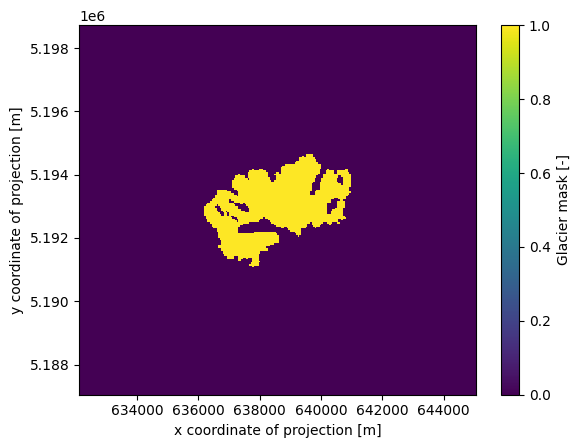

In [5]:
glacier_mask_aut = dtcg_oggm_aut.l1_datacube.glacier_mask
glacier_mask_aut.plot();

The data cubes already contain topographic information from **[Copernicus DEM - Global and European Digital Elevation Model](https://doi.org/10.5270/ESA-c5d3d65)**:

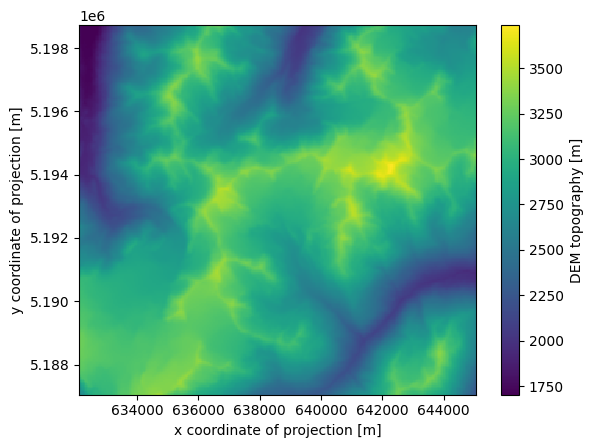

In [6]:
dtcg_oggm_aut.l1_datacube.topo.plot();

As well as:
 - ice thickness data from **[Farinotti et al. (2019)](https://doi.org/10.1038/s41561-019-0300-3)** (consensus estimate)
 - elevation change data from **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)**
 - ice velocity data from **[ITS_LIVE](https://its-live.jpl.nasa.gov/)**
 - ice velocity and ice thickness data from **[Millan et al. (2022)](https://doi.org/10.1038/s41561-021-00885-z)**

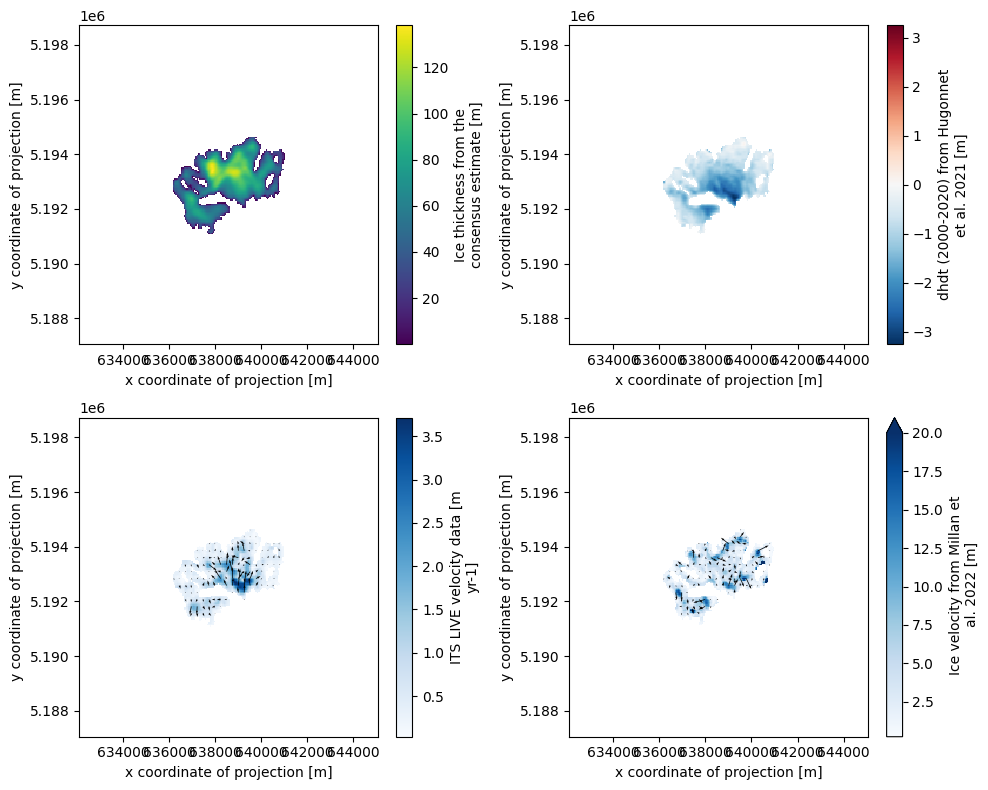

In [7]:
def plot_velocity(ax, ds, prefix, subsample=5, vmax=None):
    # subsample for vector clarity
    ds_q = ds.isel(x=slice(None, None, subsample), y=slice(None, None, subsample))
    
    # background scalar field
    ds[f"{prefix}_v"].plot(ax=ax, cmap="Blues", vmax=vmax)
    
    # vector overlay
    ax.quiver(ds_q["x"], ds_q["y"],
              ds_q[f"{prefix}_vx"], ds_q[f"{prefix}_vy"],
              color="black")

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Farinotti et al. (2019) ice thickness (consenus estimate)
dtcg_oggm_aut.l1_datacube.consensus_ice_thickness.plot(ax=axs[0, 0]);

# Hugonnet et al. (2021) height change
dtcg_oggm_aut.l1_datacube.hugonnet_dhdt.where(glacier_mask_aut).plot(ax=axs[0, 1]);

# ITS_LIVE ice velocity
plot_velocity(ax=axs[1, 0], ds=dtcg_oggm_aut.l1_datacube.where(glacier_mask_aut),
              prefix='itslive')

# Millan et al. (2022) ice velocity
plot_velocity(ax=axs[1, 1], ds=dtcg_oggm_aut.l1_datacube.where(glacier_mask_aut),
              prefix='millan', vmax=20)

plt.tight_layout()
plt.show()

## Enhance OGGM data cubes with new observations

### CryoTEMPO-EOLIS derived from CryoSat-2

As part of DTC-Glaciers we developed a method to add four **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** variables derived from **CryoSat-2** observations to the **L1** Data cubes.

| Variable | Dims | Description |
|---|---|---|
| `eolis_gridded_elevation_change` | `(t,y,x)` | Time series of spatial maps of elevation change since **January 2011**. |
| `eolis_gridded_elevation_change_sigma` | `(t,y,x)` | Uncertainty (σ) for the gridded elevation-change maps. |
| `eolis_elevation_change_timeseries` | `(t)` | Spatially aggregated 1D elevation-change series since **January 2011**. |
| `eolis_elevation_change_sigma_timeseries` | `(t)` | Uncertainty (σ) for the aggregated series. |

For this to work on your own labtop you need to register yourself on the **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** website and retrive a key. You need to provide your key to DTC-Glaciers in the following way:

In [8]:
# import os
# os.environ["SPECKLIA_API_KEY"] = ENTER YOUR SPECKLIA API KEY HERE

You can add the data using `add_data_to_l1_data cube` together with `DatacubeCryotempoEolis`. This can take some time, as up-to-date data is downloaded from the **CryoTEMPO-EOLIS** server and reprojected to the **L1** Data cubes.

In [9]:
from dtcg.datacube.cryotempo_eolis import DatacubeCryotempoEolis

dtcg_oggm_ice.add_data_to_l1_datacube(DatacubeCryotempoEolis)

dtcg_oggm_ice.l1_datacube

<xarray.Dataset> Size: 454MB
Dimensions:                                  (y: 370, x: 436, t: 173)
Coordinates:
  * y                                        (y) float32 1kB 7.201e+06 ... 7....
  * x                                        (x) float32 2kB 3.94e+05 ... 4.8...
  * t                                        (t) int64 1kB 1295049600 ... 174...
    spatial_ref                              int64 8B 0
Data variables: (12/18)
    topo                                     (y, x) float32 645kB 1.147e+03 ....
    topo_smoothed                            (y, x) float32 645kB 1.151e+03 ....
    topo_valid_mask                          (y, x) int8 161kB 1 1 1 1 ... 1 1 1
    glacier_mask                             (y, x) int8 161kB 0 0 0 0 ... 0 0 0
    glacier_ext                              (y, x) int8 161kB 0 0 0 0 ... 0 0 0
    consensus_ice_thickness                  (y, x) float32 645kB nan ... nan
    ...                                       ...
    millan_vy                                (y, x) float32 645kB nan ... nan
    hugonnet_dhdt                            (y, x) float32 645kB nan ... -0....
    eolis_gridded_elevation_change           (t, y, x) float64 223MB nan ... nan
    eolis_gridded_elevation_change_sigma     (t, y, x) float64 223MB nan ... nan
    eolis_elevation_change_timeseries        (t) float64 1kB 0.01408 ... -0.1402
    eolis_elevation_change_sigma_timeseries  (t) float64 1kB 0.8922 ... 1.059
Attributes:
    author:              OGGM
    author_info:         Open Global Glacier Model
    pyproj_srs:          +proj=utm +zone=28 +datum=WGS84 +units=m +no_defs
    max_h_dem:           1901.579
    min_h_dem:           -0.24698931
    max_h_glacier:       1875.962
    min_h_glacier:       623.5142
    glacier_attributes:  {'rgi_id': 'RGI60-06.00377', 'glims_id': 'G343733E64...
    RGI-ID:              RGI60-06.00377

Let visualise these new datasets!

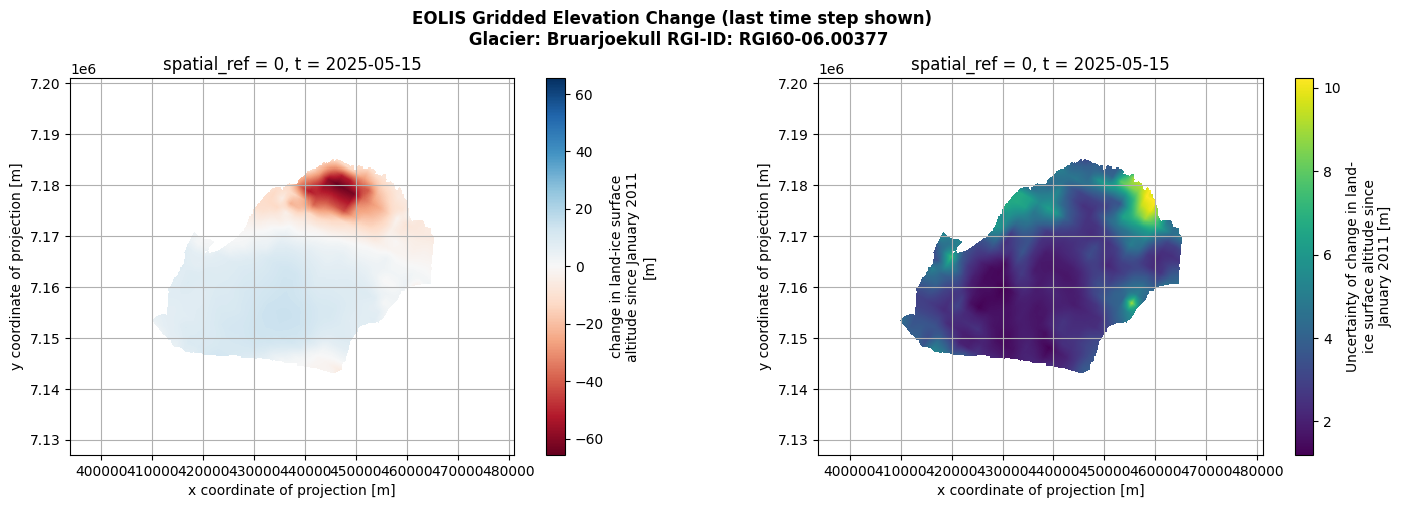

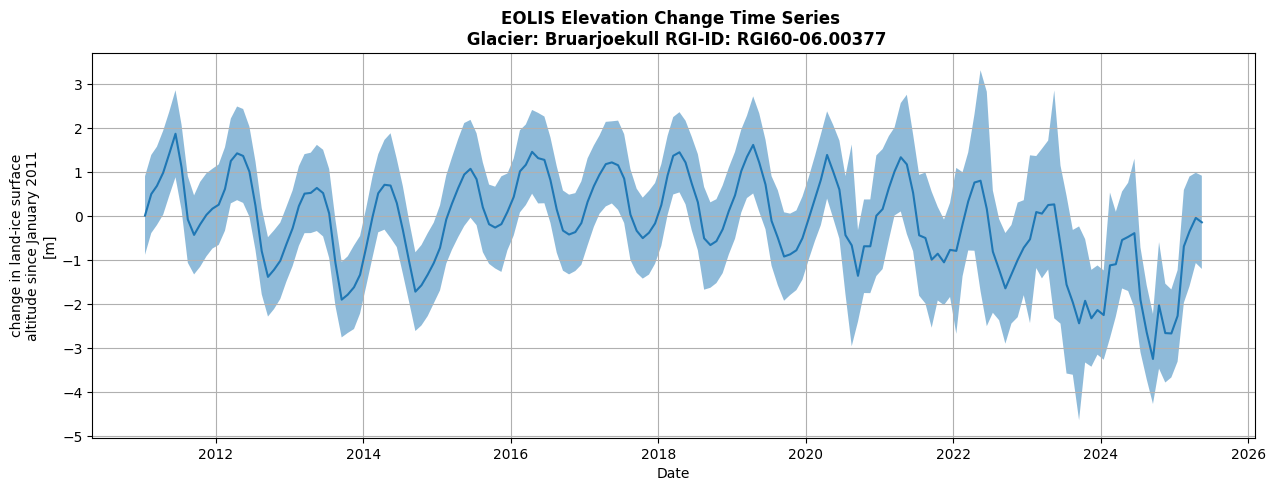

In [10]:
import xarray as xr

# decode for nice plotting (we dont do this during processing as it alters the metadata)
datacube_decoded = xr.decode_cf(dtcg_oggm_ice.l1_datacube)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
datacube_decoded.eolis_gridded_elevation_change.isel(t=-1).plot(ax=axes[0], cmap='RdBu')
datacube_decoded.eolis_gridded_elevation_change_sigma.isel(t=-1).plot(ax=axes[1])
for ax in axes:
    ax.set_aspect('equal')
    ax.grid('on')
plt.suptitle("EOLIS Gridded Elevation Change (last time step shown) \n Glacier: {} RGI-ID: {}".format(dtcg_oggm_ice.gdir.name, dtcg_oggm_ice.gdir.rgi_id),
             fontweight='bold')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
datacube_decoded.eolis_elevation_change_timeseries.plot(ax=ax)
ax.fill_between(
    datacube_decoded.t,
    datacube_decoded.eolis_elevation_change_timeseries - datacube_decoded.eolis_elevation_change_sigma_timeseries,
    datacube_decoded.eolis_elevation_change_timeseries + datacube_decoded.eolis_elevation_change_sigma_timeseries,
    alpha=0.5
)
ax.set_title("EOLIS Elevation Change Time Series \n Glacier: {} RGI-ID: {}".format(dtcg_oggm_ice.gdir.name, dtcg_oggm_ice.gdir.rgi_id),
             fontweight='bold')
ax.set_xlabel("Date")
ax.grid('on')
plt.show()

### Glacier surface classification from Sentinel-2

Within DTC-Glaciers [ENVEO](https://www.enveo.at/) provides a 10 m gridded product of glacier surface classification derived from **Sentinel-2** data, which can be added to the **L1** data cubes the same way as shown above.

| Variable | Dims | Description |
|---|---|---|
| `sfc_type_data` | `(t_sfc_type,y,x)` | Glacier surface classification. |
| `sfc_type_uncertainty` | `(t_sfc_type,y,x)` | Glacier surface classification uncertainty. |
| `sfc_type_snowline` | `(snowcover_frac, t_sfc_type)` | Snowline altitude derived from glacier surface classification for three different snow cover area fractions (25%, 50% and 75%) per 30m elevation band. |



In [11]:
from dtcg.datacube.surface_type import DatacubeSurfaceType

dtcg_oggm_aut.add_data_to_l1_datacube(DatacubeSurfaceType)

dtcg_oggm_aut.l1_datacube

<xarray.Dataset> Size: 79MB
Dimensions:                  (y: 229, x: 254, t_sfc_type: 82, snowcover_frac: 3)
Coordinates:
  * y                        (y) float32 916B 5.199e+06 5.199e+06 ... 5.187e+06
  * x                        (x) float32 1kB 6.321e+05 6.322e+05 ... 6.45e+05
  * t_sfc_type               (t_sfc_type) int64 656B 1435968000 ... 1632528000
  * snowcover_frac           (snowcover_frac) float64 24B 0.25 0.5 0.75
Data variables: (12/17)
    topo                     (y, x) float32 233kB 1.742e+03 ... 2.256e+03
    topo_smoothed            (y, x) float32 233kB 1.725e+03 ... 2.283e+03
    topo_valid_mask          (y, x) int8 58kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 58kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 58kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 233kB nan nan nan ... nan nan nan
    ...                       ...
    millan_vx                (y, x) float32 233kB nan nan nan ... nan nan nan
    millan_vy                (y, x) float32 233kB nan nan nan ... nan nan nan
    hugonnet_dhdt            (y, x) float32 233kB 0.1893 0.1624 ... 0.001232
    sfc_type_data            (t_sfc_type, y, x) float64 38MB nan nan ... nan nan
    sfc_type_uncertainty     (t_sfc_type, y, x) float64 38MB nan nan ... nan nan
    sfc_type_snowline        (snowcover_frac, t_sfc_type) float64 2kB -inf .....
Attributes:
    author:              OGGM
    author_info:         Open Global Glacier Model
    pyproj_srs:          +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs
    max_h_dem:           3737.275
    min_h_dem:           1701.9393
    max_h_glacier:       3574.82
    min_h_glacier:       2794.6978
    glacier_attributes:  {'rgi_id': 'RGI60-11.00719', 'glims_id': 'G010818E46...
    RGI-ID:              RGI60-11.00719

The **snowline** was derived for model validation within DTC-Glaciers and also could be assimilated in the future. For this we aggregated the gridded glacier surface classifiaction in **30 m elevation bands** and calculated for each band the **snow cover area fraction**, excluding cloud pixels. Afterwards we looked for the lowest elevation band where one of the three tresholds 25%, 50% and 75% where exceeded first.

Let's have a look at one example:

In [12]:
import numpy as np
import xarray as xr
from dtcg.datacube.surface_type import (
    get_categories_per_elevation_band, exclude_empty_elevation_bins,
    exclude_dates_with_to_much_cloud_cover, get_snowline)

def plot_surface_classification_per_elev_band(l1_datacube, date):
    ds_obs = get_categories_per_elevation_band(l1_datacube)
    ds_obs = exclude_empty_elevation_bins(ds=ds_obs)
    ds_obs = exclude_dates_with_to_much_cloud_cover(ds=ds_obs)

    ds_use = ds_obs.sel(t_sfc_type=date)
    ds_use = xr.decode_cf(ds_use)

    bin_idx, bin_elev = get_snowline(ds_use)
    
    fig, axs = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'wspace':0.1})
    
    ax_total = axs[0]
    ax_relative = axs[1]
    ax_uncertainty = axs[2]
    
    def plot_horizontal_stacked_bar(ax, ds, categories, var, normalize=False):
        category_dict = eval(ds[categories].attrs['code'])  # ast.literal_eval(ds[categories].attrs['code'])
        previous_values = None
        for category in ds_use[categories]:
            current_values = ds.loc[{categories: category}][var].values
            if normalize:
                number_grid_points_elev_bin = ds.category_counts.sum(dim='category')
                current_values = current_values.astype(float) / number_grid_points_elev_bin
            ax.barh(ds.elevation_bin, current_values,
                     left=previous_values,
                     label=category_dict[int(category)])
        
            if previous_values is None:
                previous_values = current_values
            else:
                previous_values = previous_values + current_values
    
        ax.invert_yaxis()
    
    plot_horizontal_stacked_bar(ax_total, ds_use, 'category', 'category_counts')
    plot_horizontal_stacked_bar(ax_relative, ds_use, 'category', 'category_counts', normalize=True)
    plot_horizontal_stacked_bar(ax_uncertainty, ds_use, 'uncertainty_flag', 'uncertainty_counts', normalize=True)

    def add_snowline(ax):
        if np.isneginf(bin_elev[1]):
            extra_label = 'fully snow covered'
        elif np.isposinf(bin_elev[1]):
            extra_label = 'fully snow free'
        else:
            extra_label = f'{bin_elev[1]:.0f} m'
        ax.axhline(bin_idx[0], color='k', linestyle='--')
        ax.axhline(bin_idx[1], color='k', linestyle='-', label=f'snowline ({extra_label})')
        ax.axhline(bin_idx[2], color='k', linestyle='--', label='snowline uncertainty')

    def set_legend(ax):
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    
    ax_total.set_yticks(ds_use.elevation_bin, [int(elev) for elev in ds_use.lower_elevation.values])
    ax_total.set_ylabel('Altitude [m]')
    ax_total.set_title('category count')
    add_snowline(ax_total)
    set_legend(ax_total)
    
    ax_relative.set_title('category count relative')
    ax_relative.set_yticklabels([])
    add_snowline(ax_relative)
    set_legend(ax_relative)
    
    ax_uncertainty.set_title('uncertainty count relative')
    ax_uncertainty.set_yticklabels([])
    add_snowline(ax_uncertainty)
    set_legend(ax_uncertainty)

    fig.suptitle(f"{l1_datacube.attrs['RGI-ID']}, {np.datetime_as_string(ds_use.t_sfc_type.values, unit='D')}")
    
    plt.show()

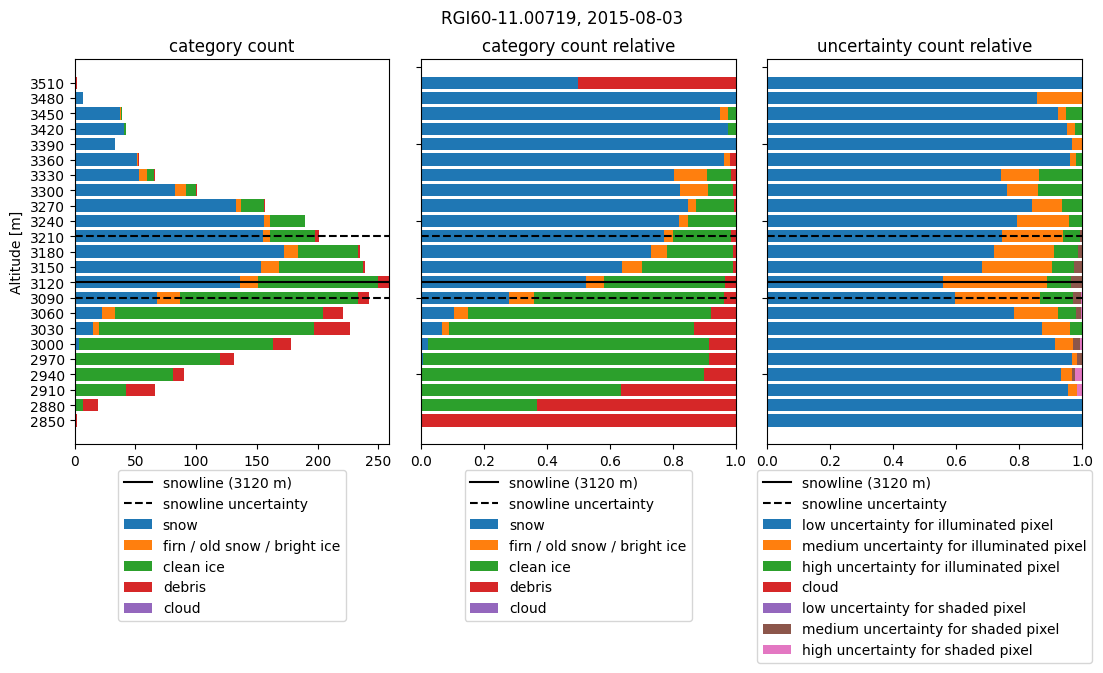

In [13]:
plot_surface_classification_per_elev_band(
    l1_datacube=dtcg_oggm_aut.l1_datacube,
    date=dtcg_oggm_aut.l1_datacube.t_sfc_type[1])

Let's visualize the derived snowline on top of the original gridded data:

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.lines as mlines


def build_categorical_colormap(class_labels, palette_name="colorblind"):

    # Extract integer classes and sort them
    classes = sorted([k for k in class_labels.keys() if isinstance(k, (int, np.integer))])
    n = len(classes)

    # Pick n colors from seaborn palette
    colors = sns.color_palette(palette_name, n)

    # Create colormap
    cmap = mcolors.ListedColormap(colors)
    
    # Set NaN color ("bad" values)
    #cmap.set_bad("lightgray")

    # Boundaries between classes — last boundary is +1
    bounds = [c - 0.5 for c in classes] + [classes[-1] + 0.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    return norm, cmap, classes


def plot_gridded_surface_classification(l1_datacube, date, x_zoom=70, y_zoom=50, snowline=None):
    
    ds_plot = l1_datacube.isel(x=slice(x_zoom, len(l1_datacube.x) - x_zoom),
                               y=slice(y_zoom, len(l1_datacube.y) - y_zoom))

    ds_plot = ds_plot.sel(t_sfc_type=date)
    ds_plot = xr.decode_cf(ds_plot)
    
    # Integer classes in your dataset
    dict_labels_1 = {0: 'unclassified',
     1: 'snow',
     2: 'firn \n old snow \n bright ice',
     3: 'clean ice',
     4: 'debris',
     5: 'cloud',
     'nan': 'no data'}#ast.literal_eval(ds_plot.sfc_type_data.code)
    
    dict_labels_2 = {1: 'low uncertainty \n illuminated pixel',
     2: 'medium uncertainty \n illuminated pixel',
     3: 'high uncertainty \n illuminated pixel',
     5: 'cloud',
     11: 'low uncertainty \n shaded pixel',
     12: 'medium uncertainty \n shaded pixel',
     13: 'high uncertainty \n shaded pixel',
     'nan': 'no data'}#ast.literal_eval(ds_plot.sfc_type_uncertainty.code)
    
    norm_1, cmap_1, classes_1 = build_categorical_colormap(dict_labels_1)
    norm_2, cmap_2, classes_2 = build_categorical_colormap(dict_labels_2)
    
    # Your data array
    da_1 = ds_plot.where(ds_plot.glacier_mask).sfc_type_data
    da_2 = ds_plot.where(ds_plot.glacier_mask).sfc_type_uncertainty
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    ax_1 = axs[0]
    ax_2 = axs[1]
    
    mappable_1 = da_1.plot(ax=ax_1, cmap=cmap_1, norm=norm_1, add_colorbar=False)
    mappable_2 = da_2.plot(ax=ax_2, cmap=cmap_2, norm=norm_2, add_colorbar=False)
    
    # add derived snowline
    
    cs = ds_plot.where(ds_plot.glacier_mask).topo_smoothed.plot.contour(
        ax=ax_1, levels=[snowline], colors='k', linewidths=0.5)
    proxy = mlines.Line2D([], [], color="k", linewidth=0.5, label=f'derived snowline at {snowline} m')
    ax_1.legend(handles=[proxy])

    cs = ds_plot.where(ds_plot.glacier_mask).topo_smoothed.plot.contour(
        ax=ax_2, levels=[snowline], colors='k', linewidths=0.5)
    proxy_2 = mlines.Line2D([], [], color="k", linewidth=0.5, label=f'derived snowline at {snowline} m')
    ax_2.legend(handles=[proxy_2])
    
    # Add labeled colorbar
    cbar_1 = plt.colorbar(mappable_1, ax=ax_1, orientation='horizontal', ticks=classes_1)
    cbar_1.ax.set_xticklabels([f"{dict_labels_1[c]}" for c in classes_1], rotation=90)
    cbar_1.set_label(ds_plot.sfc_type_data.long_name)
    
    cbar_2 = plt.colorbar(mappable_2, ax=ax_2, ticks=[1, 2, 3.5, 7.5, 11, 12, 13], orientation='horizontal')#classes_2)
    cbar_2.ax.set_xticklabels([f"{dict_labels_2[c]}" for c in classes_2], rotation=90)
    cbar_2.set_label(ds_plot.sfc_type_uncertainty.long_name)
    
    ax_1.axis('equal')
    ax_2.axis('equal')
    
    ax_1.set_title(f"{l1_datacube.attrs['RGI-ID']}, {np.datetime_as_string(da_1.t_sfc_type.values, unit='D')}")
    ax_2.set_title(f"{l1_datacube.attrs['RGI-ID']}, {np.datetime_as_string(da_2.t_sfc_type.values, unit='D')}")

    fig.tight_layout()
    plt.show()

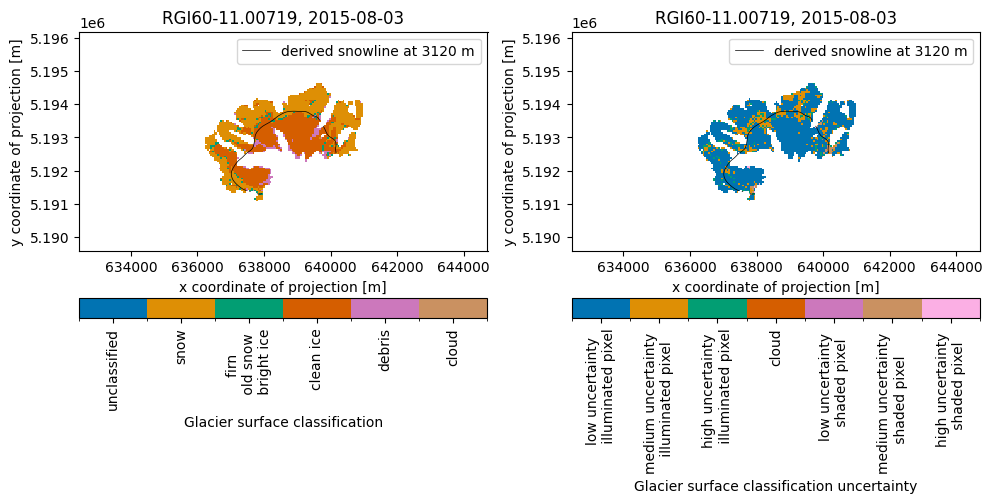

In [15]:
plot_gridded_surface_classification(
    l1_datacube=dtcg_oggm_aut.l1_datacube,
    date=dtcg_oggm_aut.l1_datacube.t_sfc_type[1],
    snowline=3120)

### In-situ mass balance observations from WGMS

For validation, DTC-Glaciers can add in-situ mass balance observations from **[WGMS](https://wgms.ch/)** to the **L1** data cubes for glaciers where those observations are available, in the same manner as seen above.

| Variable | Dims | Description |
|---|---|---|
| `wgms_mb` | `(t_wgms)` | Specific mass balance observation as reported tothe World Glacier Monitoring Service. |
| `wgms_mb_unc` | `(t_wgms)` | Specific mass balance observation uncertainty as reported to the World Glacier Monitoring Service. If no value was reported it is set to 200 mm w.e.. |

In [16]:
from dtcg.datacube.wgms import DatacubeWGMS

dtcg_oggm_ice.add_data_to_l1_datacube(DatacubeWGMS)

dtcg_oggm_ice.l1_datacube

<xarray.Dataset> Size: 454MB
Dimensions:                                  (y: 370, x: 436, t: 173, t_wgms: 32)
Coordinates:
  * y                                        (y) float32 1kB 7.201e+06 ... 7....
  * x                                        (x) float32 2kB 3.94e+05 ... 4.8...
  * t                                        (t) int64 1kB 1295049600 ... 174...
  * t_wgms                                   (t_wgms) int64 256B 1993 ... 2024
    spatial_ref                              int64 8B 0
Data variables: (12/20)
    topo                                     (y, x) float32 645kB 1.147e+03 ....
    topo_smoothed                            (y, x) float32 645kB 1.151e+03 ....
    topo_valid_mask                          (y, x) int8 161kB 1 1 1 1 ... 1 1 1
    glacier_mask                             (y, x) int8 161kB 0 0 0 0 ... 0 0 0
    glacier_ext                              (y, x) int8 161kB 0 0 0 0 ... 0 0 0
    consensus_ice_thickness                  (y, x) float32 645kB nan ... nan
    ...                                       ...
    eolis_gridded_elevation_change           (t, y, x) float64 223MB nan ... nan
    eolis_gridded_elevation_change_sigma     (t, y, x) float64 223MB nan ... nan
    eolis_elevation_change_timeseries        (t) float64 1kB 0.01408 ... -0.1402
    eolis_elevation_change_sigma_timeseries  (t) float64 1kB 0.8922 ... 1.059
    wgms_mb                                  (t_wgms) float64 256B 1.09e+03 ....
    wgms_mb_unc                              (t_wgms) float64 256B 200.0 ... ...
Attributes:
    author:              OGGM
    author_info:         Open Global Glacier Model
    pyproj_srs:          +proj=utm +zone=28 +datum=WGS84 +units=m +no_defs
    max_h_dem:           1901.579
    min_h_dem:           -0.24698931
    max_h_glacier:       1875.962
    min_h_glacier:       623.5142
    glacier_attributes:  {'rgi_id': 'RGI60-06.00377', 'glims_id': 'G343733E64...
    RGI-ID:              RGI60-06.00377

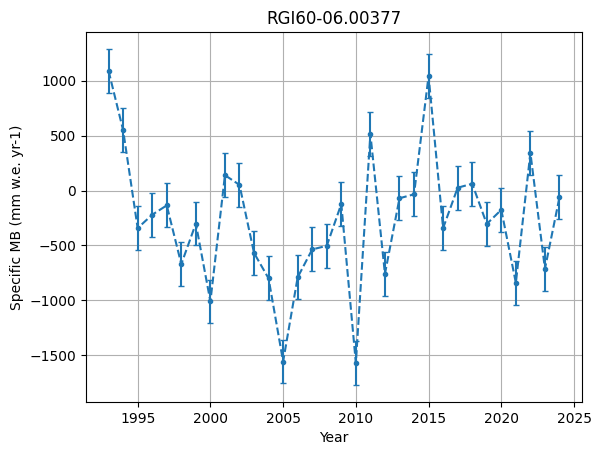

In [17]:
plt.errorbar(x=dtcg_oggm_ice.l1_datacube.t_wgms,
             y=dtcg_oggm_ice.l1_datacube.wgms_mb,
             yerr=dtcg_oggm_ice.l1_datacube.wgms_mb_unc,
             fmt=".--", capsize=2)
plt.grid("on")
plt.ylabel("Specific MB (mm w.e. yr-1)")
plt.xlabel("Year")
plt.title(dtcg_oggm_ice.l1_datacube.attrs["RGI-ID"])
plt.show()

## Apply CF Convention and Export as GeoZarr

After the creation of the enhanced **L1** Datacube we can update the metadata for all variables following the **[CF Convention](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.pdf)** by using the DTC-Glaciers `GeoZarrHandler`:

In [18]:
from dtcg.datacube.geozarr import GeoZarrHandler

datacube_handler_aut = GeoZarrHandler(dtcg_oggm_aut.l1_datacube)

datacube_handler_aut.data_tree

<xarray.DataTree>
Group: /
└── Group: /L1
        Dimensions:                  (y: 229, x: 254, t_sfc_type: 82, snowcover_frac: 3)
        Coordinates:
          * y                        (y) float32 916B 5.199e+06 5.199e+06 ... 5.187e+06
          * x                        (x) float32 1kB 6.321e+05 6.322e+05 ... 6.45e+05
          * t_sfc_type               (t_sfc_type) int64 656B 1435968000 ... 1632528000
          * snowcover_frac           (snowcover_frac) float64 24B 0.25 0.5 0.75
            spatial_ref              int64 8B 0
        Data variables: (12/17)
            topo                     (y, x) float32 233kB 1.742e+03 ... 2.256e+03
            topo_smoothed            (y, x) float32 233kB 1.725e+03 ... 2.283e+03
            topo_valid_mask          (y, x) int8 58kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
            glacier_mask             (y, x) int8 58kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
            glacier_ext              (y, x) int8 58kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
            consensus_ice_thickness  (y, x) float32 233kB nan nan nan ... nan nan nan
            ...                       ...
            millan_vx                (y, x) float32 233kB nan nan nan ... nan nan nan
            millan_vy                (y, x) float32 233kB nan nan nan ... nan nan nan
            hugonnet_dhdt            (y, x) float32 233kB 0.1893 0.1624 ... 0.001232
            sfc_type_data            (t_sfc_type, y, x) float64 38MB nan nan ... nan nan
            sfc_type_uncertainty     (t_sfc_type, y, x) float64 38MB nan nan ... nan nan
            sfc_type_snowline        (snowcover_frac, t_sfc_type) float64 2kB -inf .....
        Attributes:
            Conventions:         CF-1.12
            comment:             The DTC Glaciers project is developed under the Euro...
            date_created:        2026-01-10T21:35:56.069294
            RGI-ID:              RGI60-11.00719
            glacier_attributes:  {'rgi_id': 'RGI60-11.00719', 'glims_id': 'G010818E46...
            title:               Datacube of glacier-domain variables.
            summary:             Resampled glacier-domain variables from multiple sou...

[![Zarr logo](https://avatars.githubusercontent.com/u/35050297?s=96&v=4)](https://github.com/zarr-developers/geozarr-spec) The resulting **L1** data cube can be exported as a GeoZarr with the data cube's export function.

In [19]:
from pathlib import Path
import tempfile

with tempfile.TemporaryDirectory(suffix=".zarr") as tmpdir:
    output_path = Path(tmpdir)
    datacube_handler_aut.export(output_path)
    print(f"✅ GeoZarr exported to: {output_path}")
    items = sorted(p.name for p in output_path.iterdir())
    print("📂 Top-level contents:", ", ".join(items) or "(empty)")

✅ GeoZarr exported to: /tmp/tmp13996n7g.zarr
📂 Top-level contents: .zattrs, .zgroup, .zmetadata, L1


## Preprocessed data cubes for case study regions

Preprocessed **L1** data cubes include all currently supported observations, for the case study regions in Iceland and Austria are available at https://cluster.klima.uni-bremen.de/~dtcg/data cubes_case_study_regions/L1/ and are available at and can be streamed via:

In [20]:
# TODO
datacube_url = "https://cluster.klima.uni-bremen.de/~dtcg/datacubes_case_study_regions/L1/"
def get_data_tree(rgi_id):
    return xr.open_datatree(
            f"{datacube_url}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )

These, together with the **L2** data cubes explained in [this notebook](02_L2_datacubes.ipynb) are available for all RGI6 glaciers of Vatnajökull ([view in OpenStreetMap](https://www.openstreetmap.org/#map=8/64.438/-17.312)):

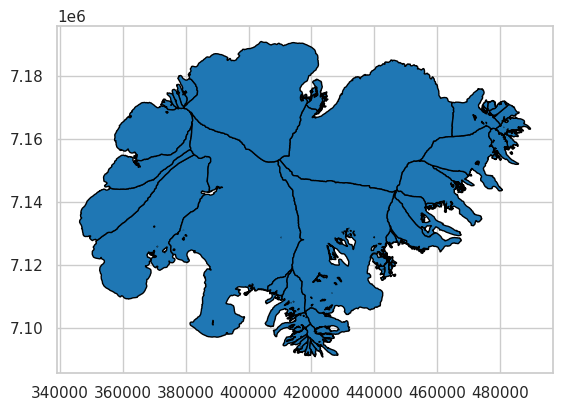

In [21]:
from oggm import utils
import yaml
import geopandas as gpd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

dtcf_url = 'https://cluster.klima.uni-bremen.de/~dtcg/test_files/case_study_regions/iceland/'
with open(utils.file_downloader(dtcf_url + 'vatnajokull_rgi_ids.yml'), 'r') as yaml_file:
    rgi_ids = yaml.safe_load(yaml_file)['rgi_ids']

# Select the outlines from RGI6 file and convert to UTM
rgi_file = gpd.read_file(utils.get_rgi_region_file('06'))
rgi_file = rgi_file.loc[rgi_file.RGIId.isin(rgi_ids)].set_index('RGIId')
rgi_file = rgi_file.to_crs('EPSG:32628')

rgi_file.plot(ec='k');

Another example is the Ötztal region in the Austrian Alps ([view in OpenStreetMap](https://www.openstreetmap.org/#map=10/46.9864/10.9101)):

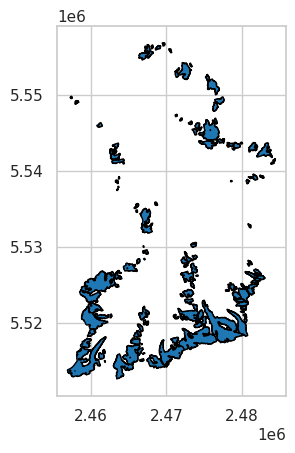

In [22]:
import json

dtcf_url = 'https://cluster.klima.uni-bremen.de/~dtcg/test_files/case_study_regions/austria/'
with open(utils.file_downloader(dtcf_url + 'oeztal_rgi_ids.json'), 'r') as json_file:
    rgi_ids = json.load(json_file)

# Select the outlines from RGI6 file and convert to UTM
rgi_file = gpd.read_file(utils.get_rgi_region_file('11'))
rgi_file = rgi_file.loc[rgi_file.RGIId.isin(rgi_ids)].set_index('RGIId')
rgi_file = rgi_file.to_crs('EPSG:32628')

rgi_file.plot(ec='k');

To get the RGI6-ID of the glacier you are interested in you can use the [GlimsViewer](https://www.glims.org/maps/glims). You need to enable the RGIv6-IDs in the menu in the top right corner, zoom to the glacier outline of interest and click on it to display its metadata.